# Sunspots Data Predict

## Import Library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split, TensorDataset

import pytorch_lightning as pl
from pytorch_lightning.metrics import functional as FM

from GetData import SunspotData

## Define Model

In [2]:
class Model(pl.LightningModule):
    def __init__(self, loss_fn, metrics_fn=[], optim=torch.optim.Adam, lr=1e-3):
        super().__init__()
        self.metrics_fn = metrics_fn
        self.loss_fn = loss_fn
        self.optim = optim
        self.lr = lr
        
        self.rnn = nn.LSTM(1, 64, 2, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(64, 32),
            nn.ELU(),
            nn.Linear(32, 1)
        )
        
    def forward(self, X):
        h0 = Variable(torch.zeros(2, X.size(0), 64)).cuda()
        c0 = Variable(torch.zeros(2, X.size(0), 64)).cuda()
        X, (hn, cn) = self.rnn(X, (h0, c0))
        return self.fc(X[:, -1, :])
        
    def configure_optimizers(self):
        return self.optim(self.parameters(), lr=self.lr)
    
    def forward_batch(self, batch):
        X, y = batch
        return self.forward(X), y
    
    def log_metrics(self, h, y, step_name):
        metrics = {'{}/{}'.format(name, step_name) : fn(h, y) for fn, name in self.metrics_fn}
        metrics['loss/{}'.format(step_name)] = self.loss_fn(h, y)
        self.log_dict(metrics, on_step=False, on_epoch=True)
        return metrics['loss/{}'.format(step_name)]
    
    def training_step(self, train_batch, batch_idx):
        h, y = self.forward_batch(train_batch)
        return self.log_metrics(h, y, 'train')

    def validation_step(self, valid_batch, batch_idx):
        h, y = self.forward_batch(valid_batch)
        self.log_metrics(h, y, 'valid')
    
    def test_step(self, test_batch, batch_idx):
        h, y = self.forward_batch(test_batch)
        self.log_metrics(h, y, 'test')
        return h, y
    
    def test_epoch_end(self, outputs):
        h, y = zip(*outputs)
        h = torch.flatten(torch.cat(h, 0)).cpu().numpy()
        y = torch.flatten(torch.cat(y, 0)).cpu().numpy()
        plt.scatter(y, h)
        plt.show()

## Train And Predict

In [3]:
data_module = SunspotData(264, batch_size=128)
model = Model(F.mse_loss, metrics_fn=[(FM.mean_absolute_error, 'mae')])
trainer = pl.Trainer(gpus=1, max_epochs=100)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [4]:
trainer.fit(model, datamodule=data_module)


  | Name | Type       | Params
------------------------------------
0 | rnn  | LSTM       | 50.4 K
1 | fc   | Sequential | 2.1 K 
------------------------------------
52.5 K    Trainable params
0         Non-trainable params
52.5 K    Total params


1

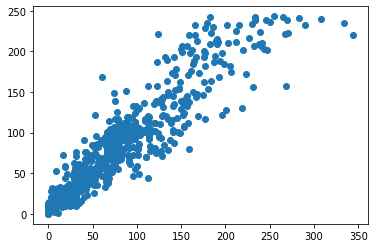


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss/test': tensor(659.6406, device='cuda:0'),
 'mae/test': tensor(18.3385, device='cuda:0')}
--------------------------------------------------------------------------------


[{'mae/test': 18.338516235351562, 'loss/test': 659.640625}]

In [5]:
trainer.test(datamodule=data_module)